In [14]:
import pandas as pd
import numpy as np
import os.path 
import pandas_datareader.data as web
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean
import time

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# unfortunately web APIs have query limits, so we switch to grabbing data from a downloaded database and may slight
# corresponding adjustments. each stock's data is contained in its own file and has the same columns of interest as
# are returned from the web query

def grab_data(file):
    
    path = './stock-data/Stocks/'+file
    data = pd.read_csv(path)
    data.Date = data.Date.apply(lambda x: np.datetime64(x))
    data.set_index('Date',inplace=True)
    
    return data.copy()

In [3]:
class stock:
    def __init__(self,file):
        self.ticker = file[:-7]
        self.data = grab_data(file)
            
    def grab_returns(self,window=2,featurelength=255):
        self.window=window
        self.featurelength = featurelength
        self.returns = self.data.Close.pct_change(periods=self.window)
        self.maxreturn = self.returns.max()
        self.maxend = np.datetime64(self.returns[self.returns==self.maxreturn].index[0])
        self.maxbegin = self.returns.loc[self.returns.index<=self.maxend].tail(self.window).index[0]
        self.maxreturndata = self.data.loc[(self.data.index<=self.maxend)&(self.data.index>=(self.maxbegin))]
        self.maxoneyear = self.data[(self.data.index<=self.maxend) & (self.data.index>=(self.maxbegin-np.timedelta64(366,'D')))]
        self.featurewindow = self.data[self.data.index<self.maxbegin][-(featurelength+200):]
        self.featurewindow['MA200'] = self.featurewindow.Close.rolling(window=200).mean()
        self.featurewindow['MA100'] = self.featurewindow.Close.rolling(window=100).mean()
        self.featurewindow['MA50'] = self.featurewindow.Close.rolling(window=50).mean()
        self.featurewindow['MA20'] = self.featurewindow.Close.rolling(window=20).mean()
        self.featurewindow['MA10'] = self.featurewindow.Close.rolling(window=10).mean()
        self.featurewindow = self.featurewindow[-(featurelength+1):].drop(['Open','High','Low','OpenInt'],axis=1)
        self.featurewindow['index'] = list(range(len(self.featurewindow)))
        self.featurewindow.set_index('index',append=True,inplace=True)
        self.featurewindowP = self.data[(self.data.index>self.maxend)][:featurelength]
        
        
    def normalize(self,mode='avg'):
        if mode=='pct':
            self.featurewindow.loc[:,'Close'] = self.featurewindow.pct_change().loc[:,'Close']
            self.featurewindow.loc[:,'MA200'] = self.featurewindow.pct_change().loc[:,'MA200']
            self.featurewindow.loc[:,'MA100'] = self.featurewindow.pct_change().loc[:,'MA100']
            self.featurewindow.loc[:,'MA50'] = self.featurewindow.pct_change().loc[:,'MA50']
            self.featurewindow.loc[:,'MA20'] = self.featurewindow.pct_change().loc[:,'MA20']
            self.featurewindow.loc[:,'MA10'] = self.featurewindow.pct_change().loc[:,'MA10']
            self.featurewindow.dropna(inplace=True)
            
        if mode=='avg':
            for col in self.featurewindow.columns:
                if col == 'Volume':
                    continue
                self.featurewindow.loc[:,col] = (self.featurewindow[col]-self.featurewindow[col].mean())/self.featurewindow[col].std()
        
            for col in self.featurewindowP.columns:
                self.featurewindowP.loc[:,col] = (self.featurewindowP[col]-self.featurewindowP[col].mean())/self.featurewindowP[col].std()
            
            for col in self.maxreturndata.columns:
                self.maxreturndata.loc[:,col] = (self.maxreturndata[col]-self.maxreturndata[col].mean())/self.maxreturndata[col].std()
            
    def engineer_features(self,mode='basic',count=2):
        self.features = []
        
        if mode == 'basic':
            for col in self.featurewindow.columns:
                self.features += list(self.featurewindow[col])
                
        if mode == 'discrete':
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count-1))*k)
            points[len(points)-1] = self.featurelength-1
            self.featuretemp = self.featurewindow.iloc[points].copy()
            for col in self.featuretemp.columns:
                self.features += list(self.featuretemp[col])
            del self.featuretemp
            
        if mode == 'interval': # only takes the avg closing prices (should normalize first) and volume over the intervals
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count))*k)
            points[len(points)-1] = self.featurelength-1
            for k in range((count-1)):
                self.features += [self.featurewindow.iloc[points[k]:points[k+1]].Close.mean()]
            for k in range((count-1)):
                self.features += [self.featurewindow.iloc[points[k]:points[k+1]].Volume.mean()]
                
        if mode == 'interval_g': # take the geometric mean of daily returns over each interval. need to normalize to %s first
            points = []
            for k in range(count):
                points.append(int(len(self.featurewindow)/(count-1))*k)
            points[len(points)-1] = self.featurelength-1
            for k in range((count-1)):
                if k == (count - 2):
                        self.features += [gmean(self.featurewindow.iloc[points[k]:(points[k+1]+1)].Close+1)-1]
                        continue
                self.features += [gmean(self.featurewindow.iloc[points[k]:points[k+1]].Close+1)-1]

In [4]:
k1 = 2
k2 = 3
k3 = 5

#stock_df1 = pd.DataFrame(columns=list(range(k1-1)))
#stock_df2 = pd.DataFrame(columns=list(range(k2-1)))
#stock_df3 = pd.DataFrame(columns=list(range(k3-1)))

for file in os.listdir('./stock-data/Stocks'):
    continue
    try:
        stk = stock(file)
        stk.grab_returns(window=25)
        stk.normalize(mode='pct')
        
        stk.engineer_features(mode='interval_g',count=k1)
        temp1 = [stk.ticker.upper()]+[stk.featurewindow.index.get_level_values(0)[0]]+stk.features
        stock_df1 = stock_df1.append(pd.DataFrame(temp1).transpose())
        
        stk.engineer_features(mode='interval_g',count=k2)
        temp2 = [stk.ticker.upper()]+stk.features
        stock_df2 = stock_df2.append(pd.DataFrame(temp2).transpose())
        
        stk.engineer_features(mode='interval_g',count=k3)
        temp3 = [stk.ticker.upper()]+stk.features
        stock_df3 = stock_df3.append(pd.DataFrame(temp3).transpose())
        del stk
    except:
        continue
        
#stock_df1.columns=(['ticker','begin_date']+list(range(len(stock_df1.columns)-2)))
#stock_df1 = stock_df1.set_index(['ticker','begin_date'])
#symbols_dates = stock_df1.drop(0,axis=1).copy()
#stock_df1.reset_index(inplace=True)
#stock_df1.drop('begin_date',axis=1,inplace=True)
#stock_df1 = stock_df1.set_index('ticker')

#stock_df2.columns=(['ticker']+list(range(len(stock_df2.columns)-1)))
#stock_df2 = stock_df2.set_index('ticker')

#stock_df3.columns=(['ticker']+list(range(len(stock_df3.columns)-1)))
#stock_df3 = stock_df3.set_index('ticker')

In [5]:
#symbols_dates = symbols_dates[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]
#stock_df1 = stock_df1[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]
#stock_df2 = stock_df2[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]
#stock_df3 = stock_df3[list(stock_df2[0].notnull().values) and list(stock_df3[0].notnull().values)]

In [6]:
#symbols_dates.to_csv('./results/first-sample/symbols-dates.csv')
#stock_df1.to_csv('./results/first-sample/df1.csv',index=False)
#stock_df2.to_csv('./results/first-sample/df2.csv',index=False)
#stock_df3.to_csv('./results/first-sample/df3.csv',index=False)

symbols_dates = pd.read_csv('./results/first-sample/symbols-dates.csv')
stock_df1 = pd.read_csv('./results/first-sample/df1.csv')
stock_df2 = pd.read_csv('./results/first-sample/df2.csv')
stock_df3 = pd.read_csv('./results/first-sample/df3.csv')

In [22]:
from sklearn.cluster import KMeans

tic = time.time()

KM1 = KMeans(n_clusters=3,random_state=2).fit(stock_df1.values)
KM2 = KMeans(n_clusters=9,random_state=2).fit(stock_df2.values)
KM3 = KMeans(n_clusters=81,random_state=2).fit(stock_df3.values)

toc = time.time()

In [23]:
print(toc-tic)

5.030459880828857


In [24]:
len(KM3.labels_)

4963

In [25]:
intermediate_labels = pd.DataFrame()

intermediate_labels['one'] = KM1.labels_
intermediate_labels['two'] = KM2.labels_
intermediate_labels['four'] = KM3.labels_

merge_list = [pd.get_dummies(intermediate_labels.one),
              pd.get_dummies(intermediate_labels.two),
              pd.get_dummies(intermediate_labels.four)]

In [26]:
dummies = pd.concat(merge_list,axis=1)
dummies.columns = list(range(93))

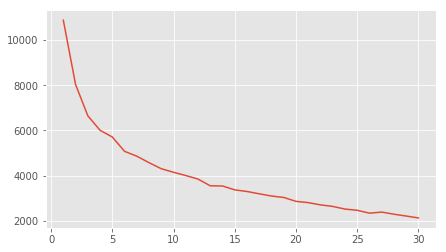

In [61]:
SS = []

for k in range(1,31):
    KM_FINAL = KMeans(n_clusters=k,random_state=2).fit(dummies.values)
    SS.append(KM_FINAL.inertia_)

fig, ax = plt.subplots(1,1,figsize=(7,4))

ax.plot(range(1,31),SS)

In [35]:
KM_FINAL = KMeans(n_clusters=13,random_state=2).fit(dummies.values)
symbols_dates['CLUSTERS'] = KM_FINAL.labels_

In [41]:
symbols_dates.CLUSTERS.value_counts().sort_values(ascending=False)

3     754
1     722
0     677
2     515
7     405
5     393
6     270
4     248
10    248
9     209
11    199
8     172
12    151
Name: CLUSTERS, dtype: int64

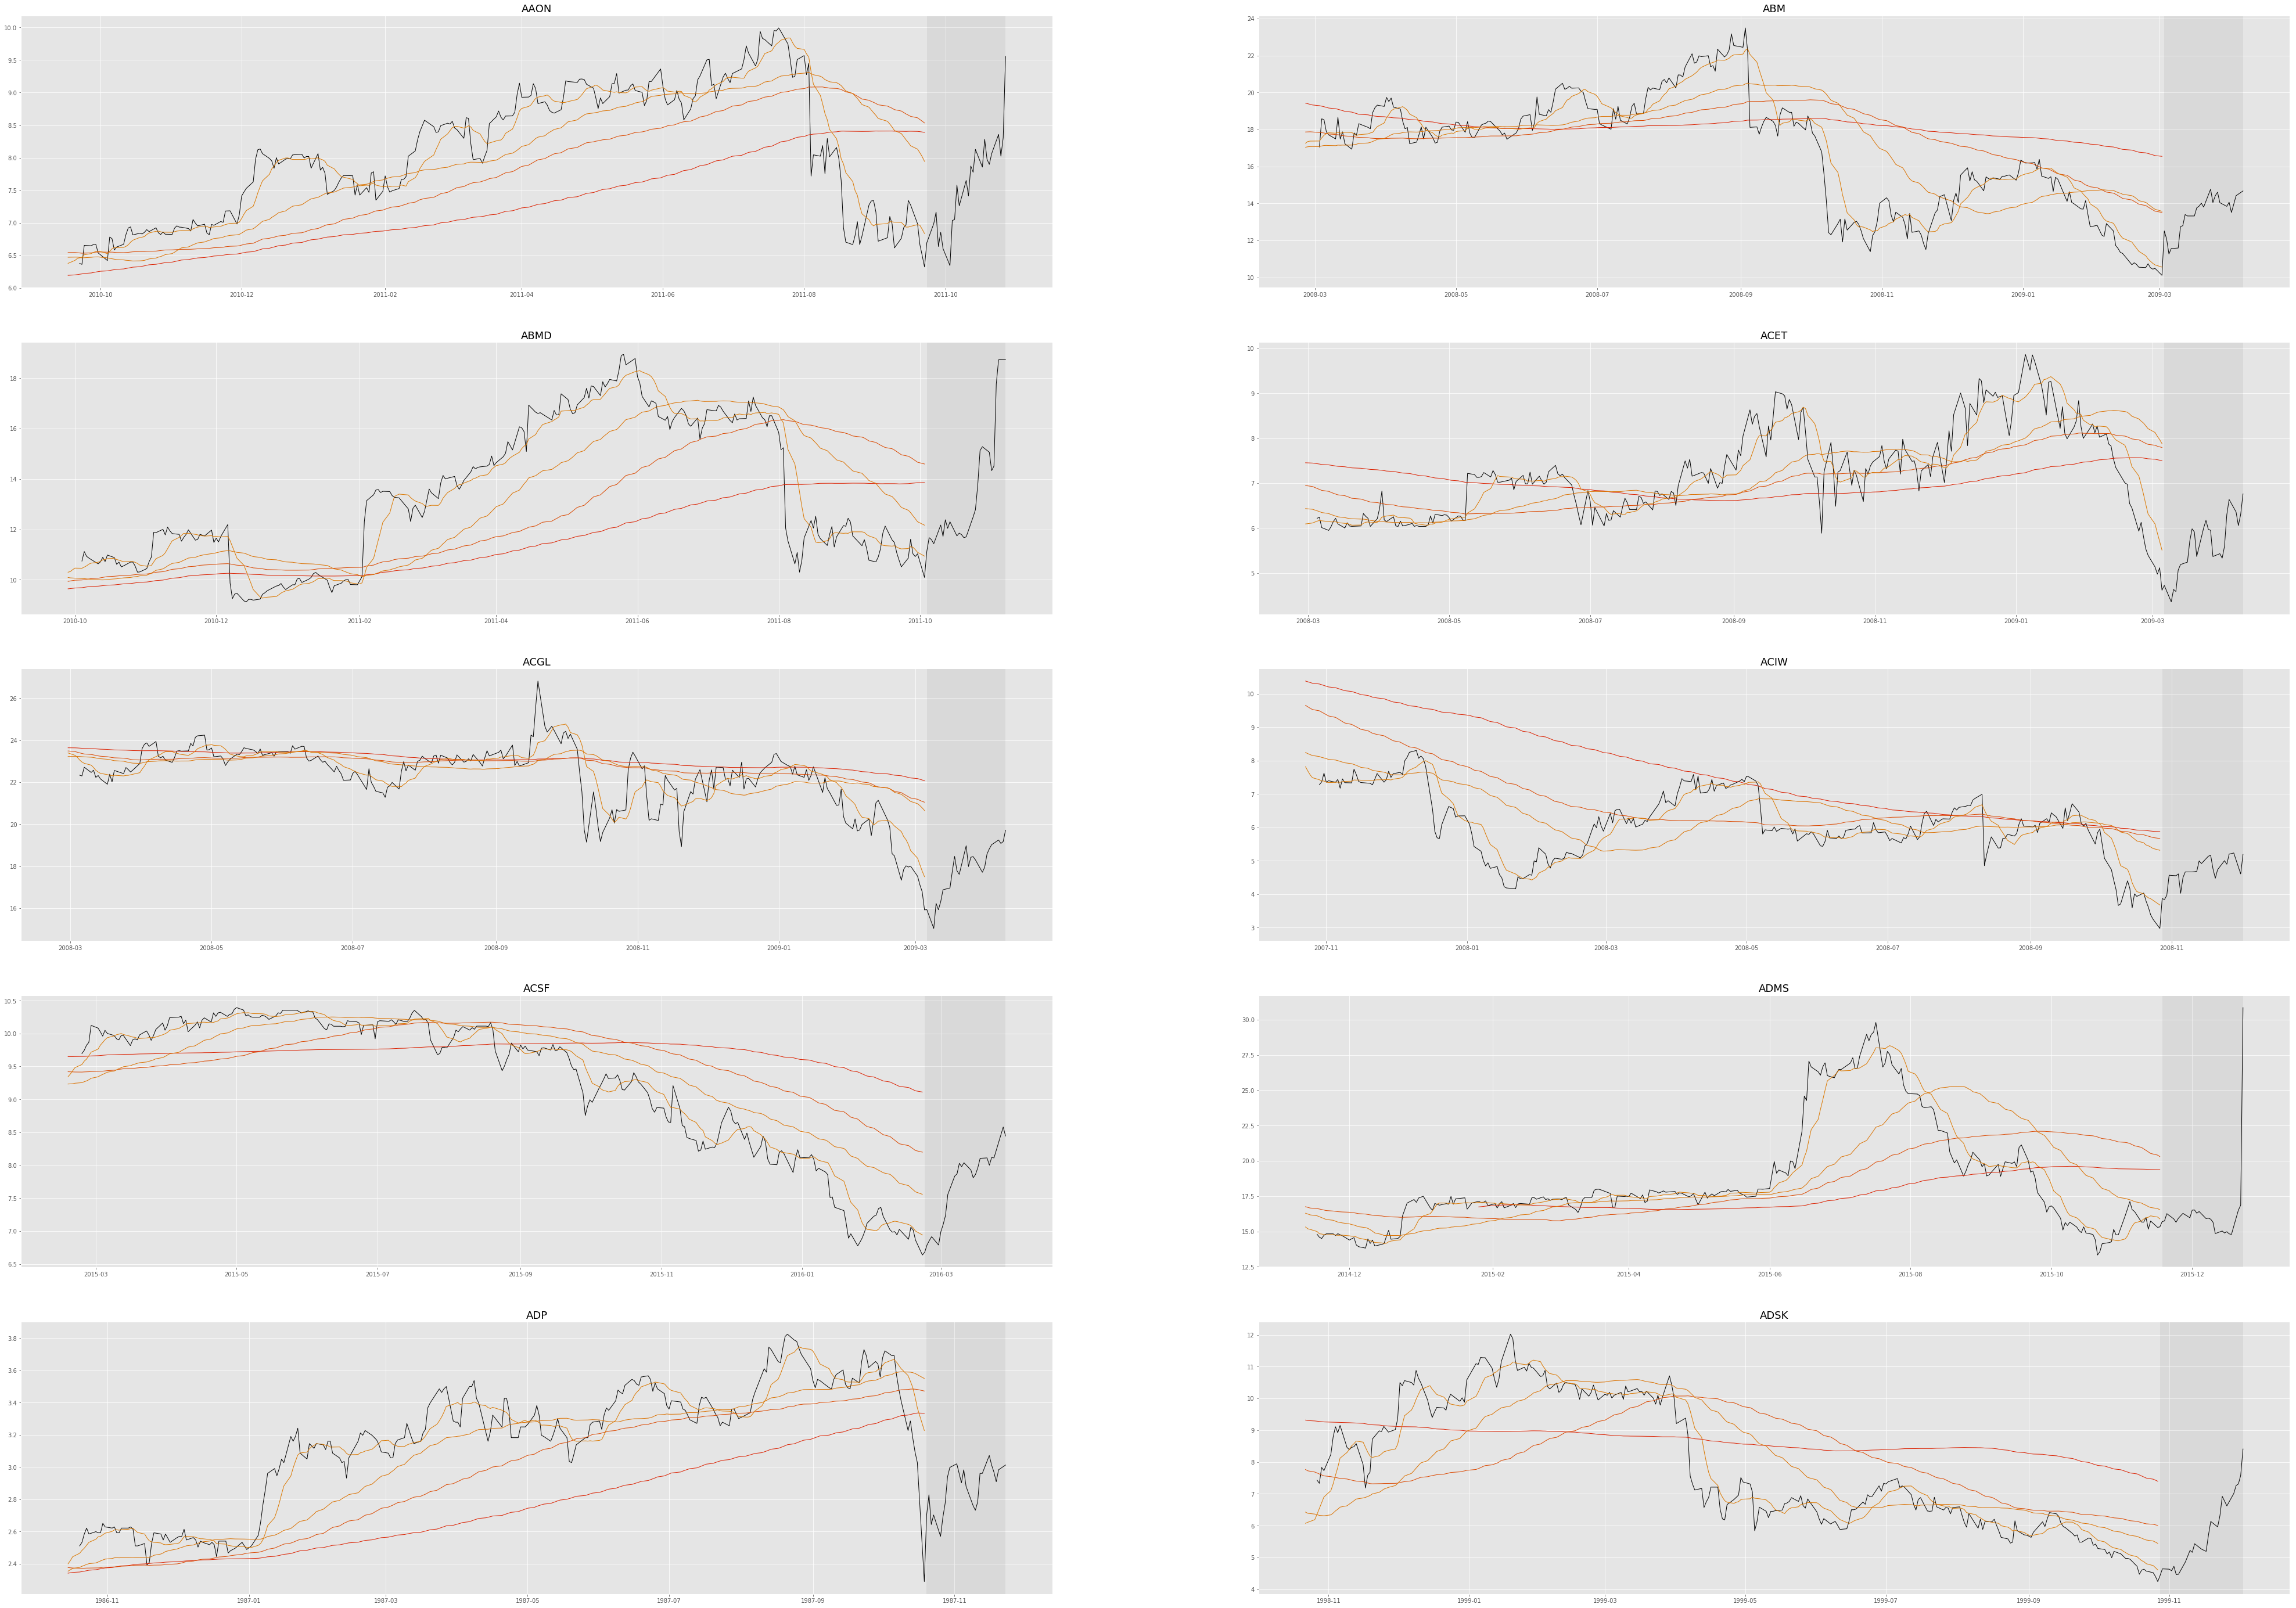

In [63]:
# within a cluster there seems to be disjoint groups of 'sub-clusters' that are more alike with each other than with 
# members of the other 'sub-clusters.' (e.g. AAON, ABMD, ADP, ACET have similar behavior with each other, whereas 
# ACGL, ACSF, ABM, ACIW, ADSK seem to form a different 'sub-cluster')

# this is likely a result of the sequential-ensemble approach taken. to further separate sub-clusters to develop more
# distinct and consistent groupings, we can apply another round of clustering within each cluster 

# note that the moving averages (red/orange hue lines) are not used to engineer features -- they are for illustrative
# purposes of the price behavior

fig = plt.figure(figsize=(70,50))

for i,tck in enumerate(symbols_dates[symbols_dates.CLUSTERS==3].ticker[:10]):
    file = tck.lower()+'.us.txt'
    b = stock(file)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(5,2,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck,fontsize=18)

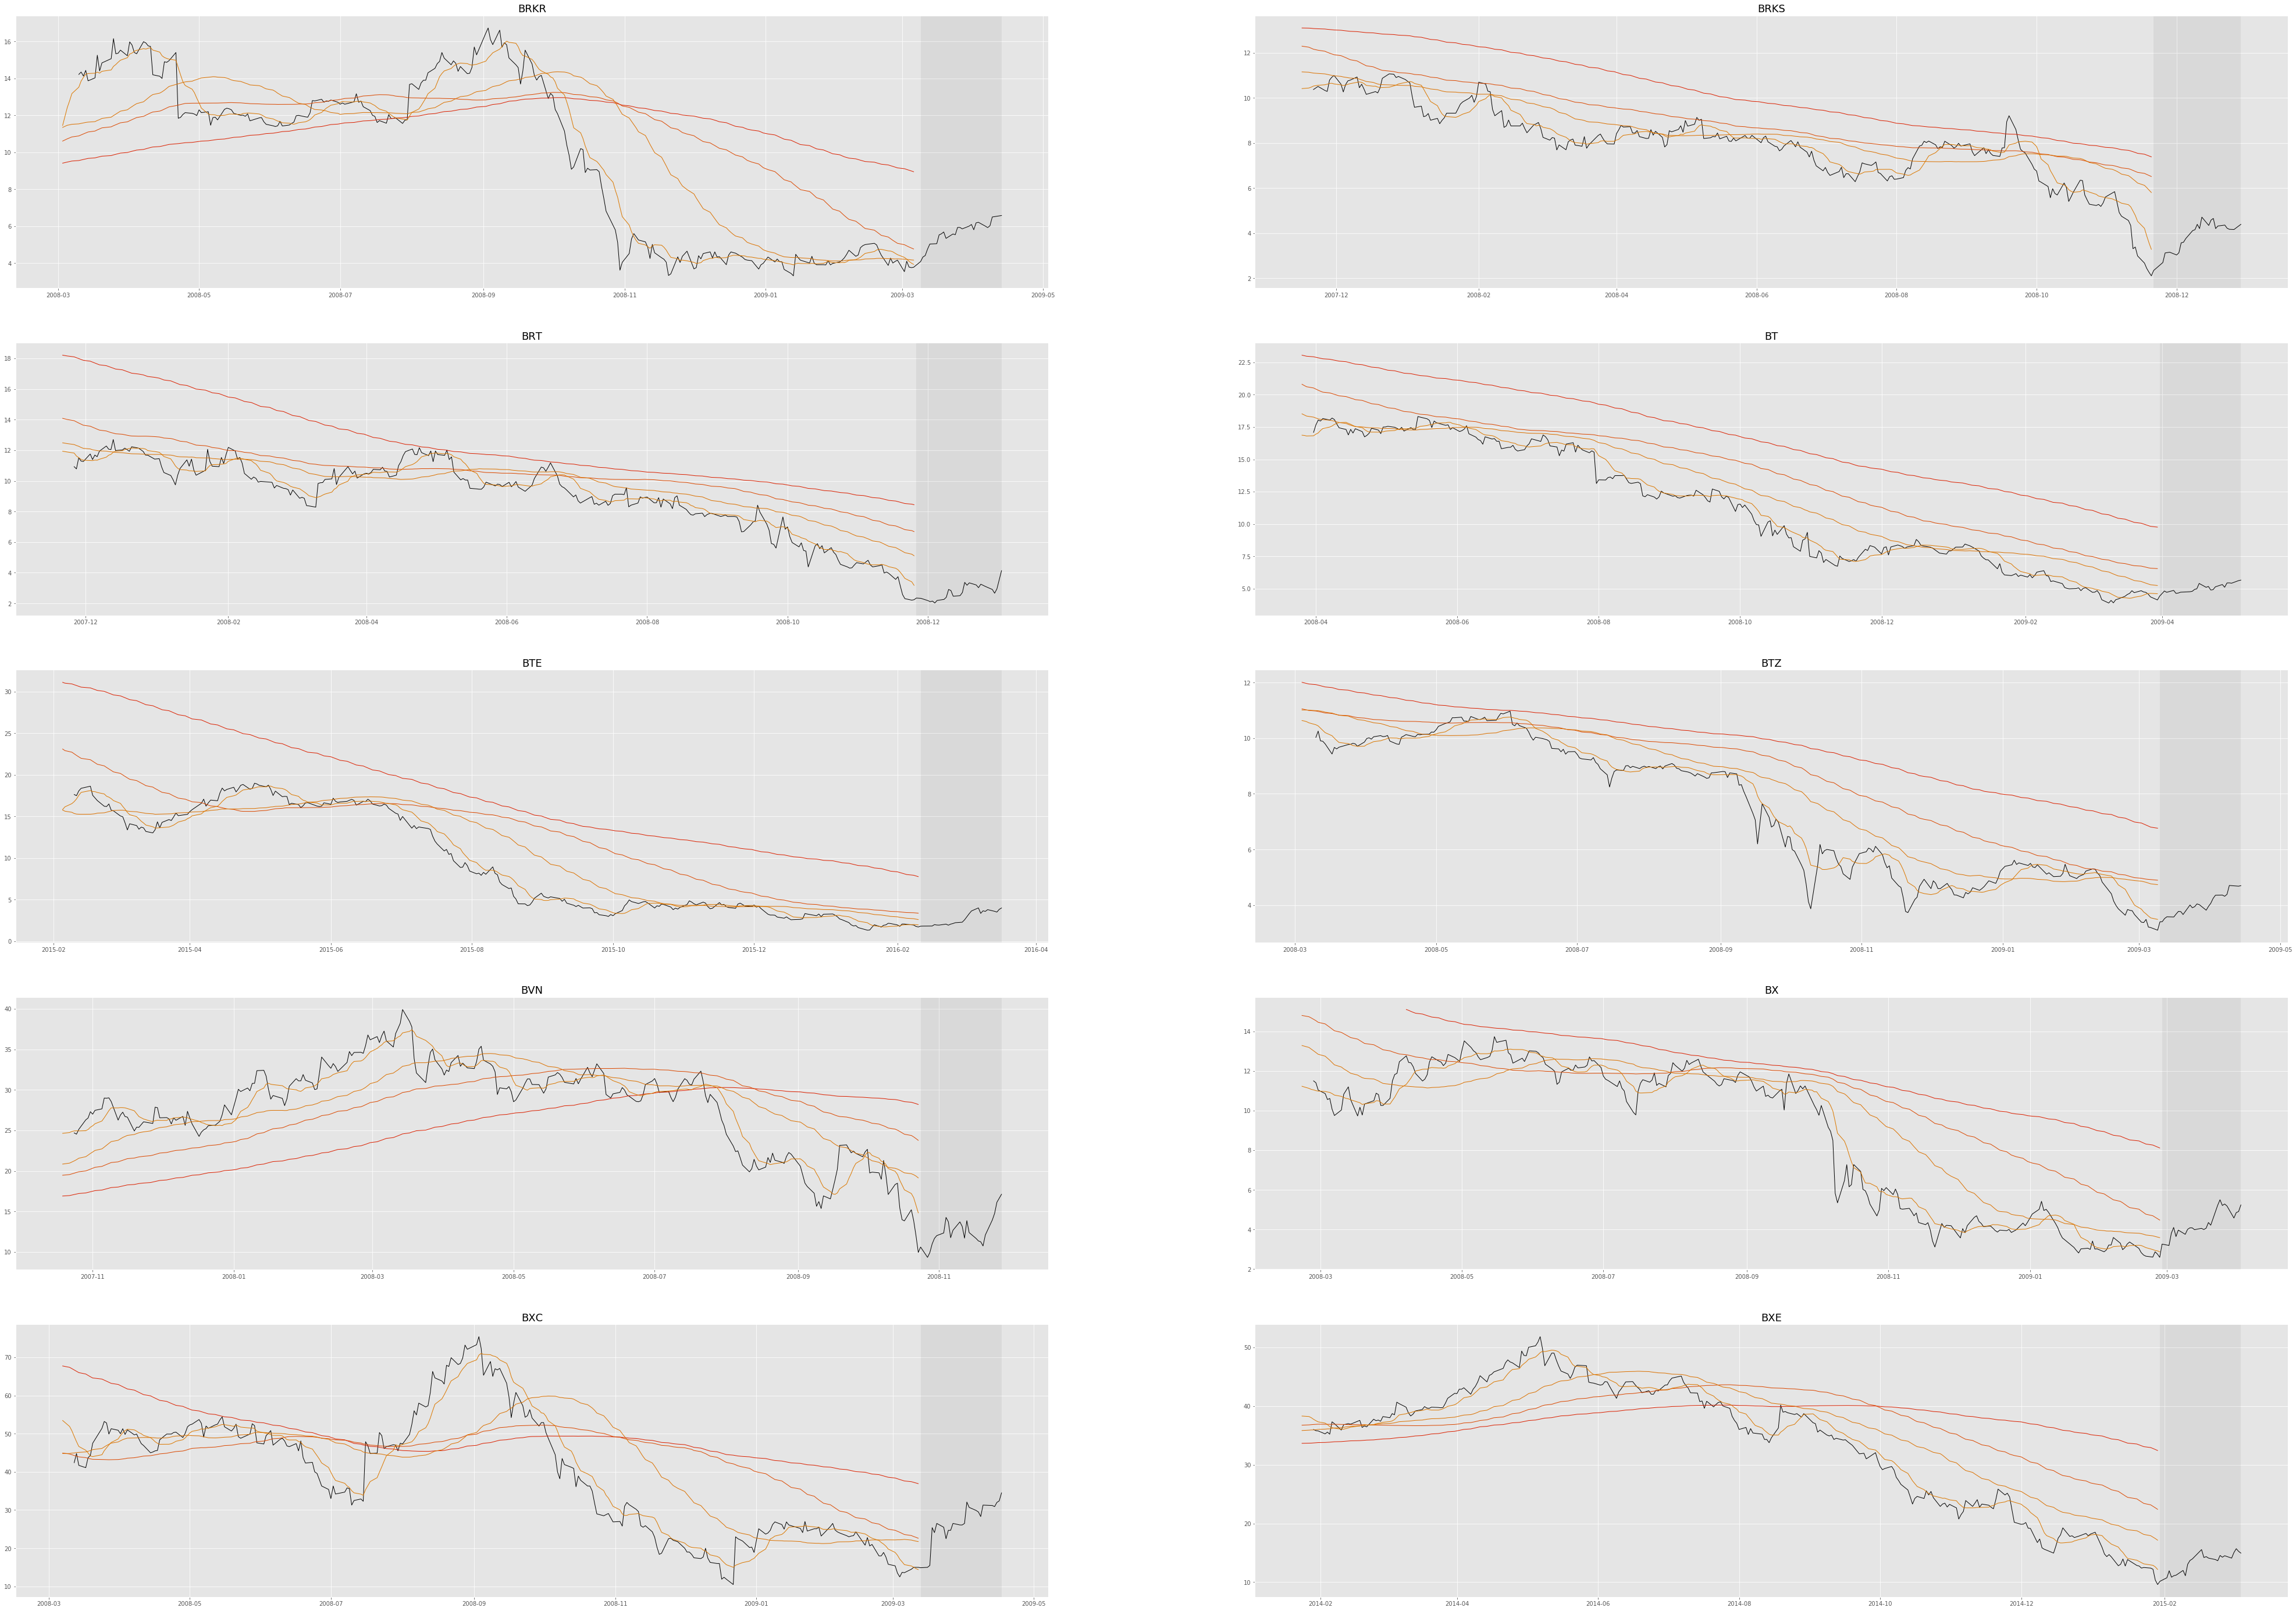

In [64]:
# sample of another cluster. again, there are members which distinctly seem to form sub-clusters. 

fig = plt.figure(figsize=(70,50))

for i,tck in enumerate(symbols_dates[symbols_dates.CLUSTERS==1].ticker[100:110]):
    file = tck.lower()+'.us.txt'
    b = stock(file)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(5,2,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck,fontsize=18)

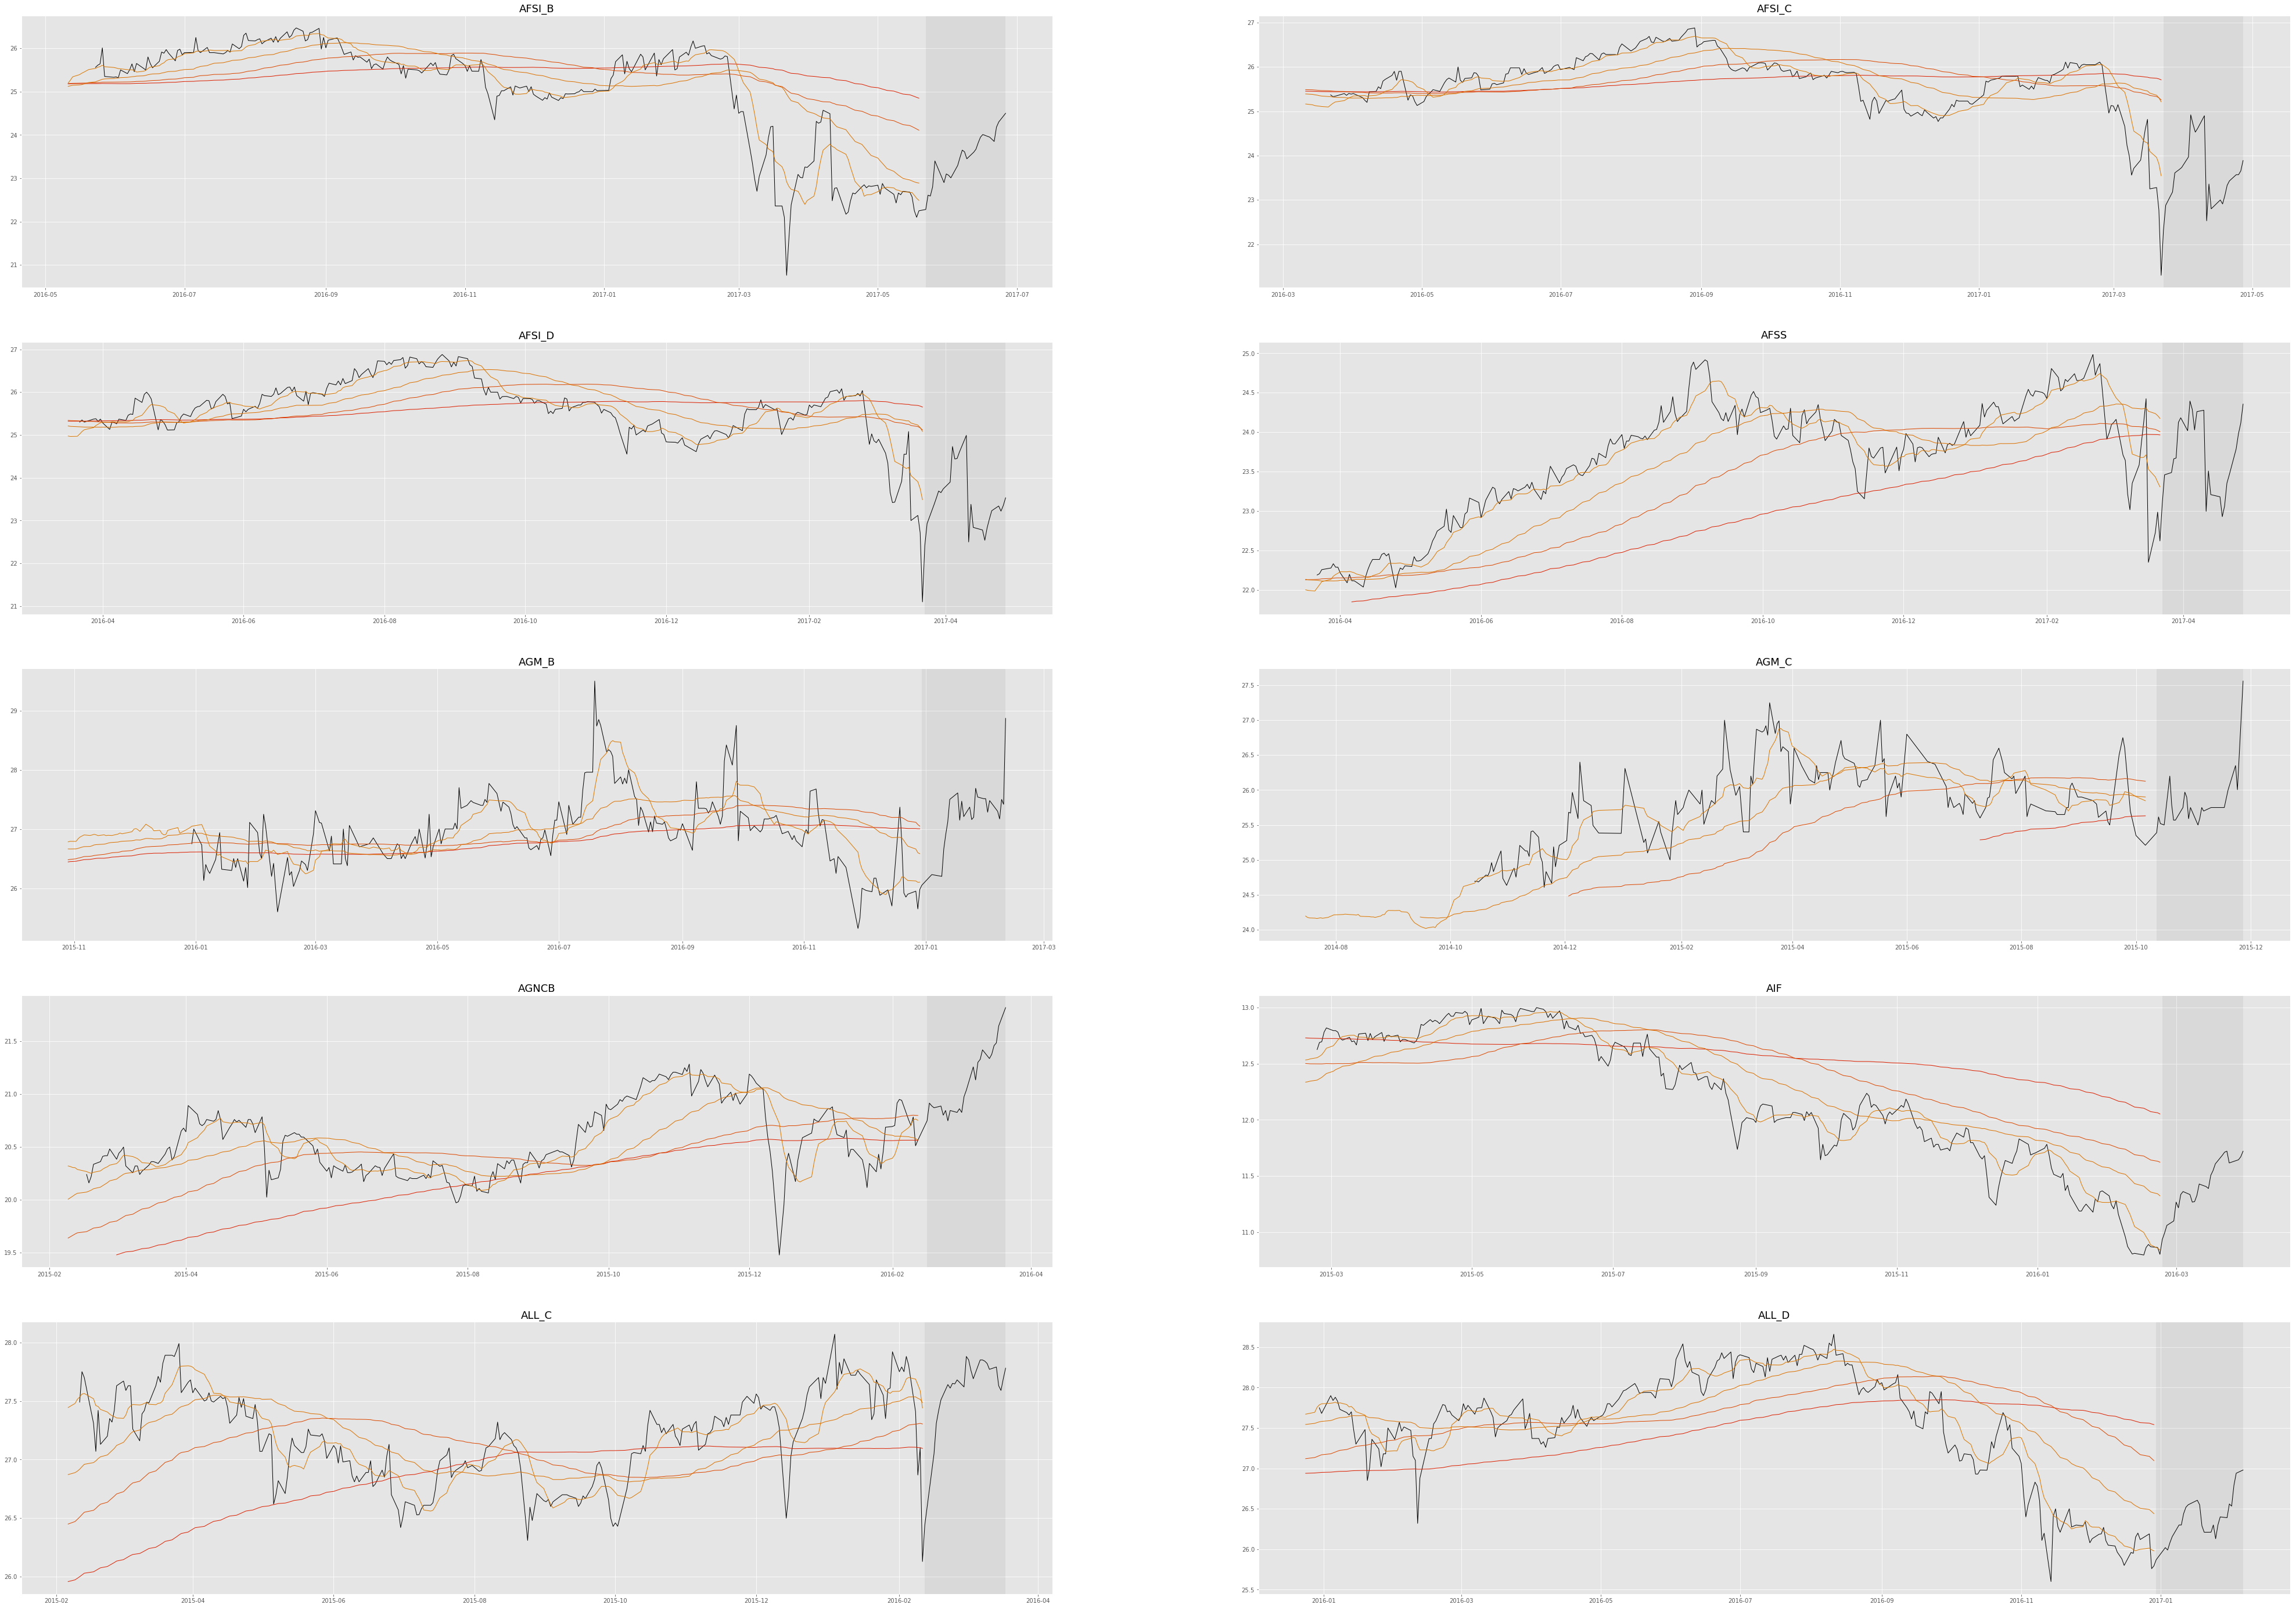

In [69]:
# some clusters contain members which seem more similar to members of other clusters than with members of their own
# another alternative approach: use 1, 2, 4 interval geometric means as features for a single run of KMeans
# rather than applying it sequentially after first running it three times for each interval count

# it also seems including volatility of returns over each interval would give better clusters

fig = plt.figure(figsize=(70,50))

for i,tck in enumerate(symbols_dates[symbols_dates.CLUSTERS==2].ticker[10:20]):
    file = tck.lower()+'.us.txt'
    b = stock(file)
    b.grab_returns(window=25)
    
    ax1 = fig.add_subplot(5,2,i+1)
    
    ax1.plot(b.maxoneyear.index.get_level_values(0),b.maxoneyear.Close,'k',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA200,'#db2000',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA100,'#db4800',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA50,'#db7100',linewidth=1)
    ax1.plot(b.featurewindow.index.get_level_values(0),b.featurewindow.MA10,'#db7800',linewidth=1)
    ax1.axvspan(b.maxbegin,b.maxend,facecolor='k',alpha=0.05)
    ax1.set_title(tck,fontsize=18)